In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import TimeDistributed, RepeatVector, MaxPooling1D, Conv1D, Flatten, Input, Reshape, BatchNormalization
from keras.layers.recurrent import LSTM, GRU
from tensorflow.keras.layers.experimental import RandomFourierFeatures
from keras.models import Sequential, Model
from keras import optimizers
import keras
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2021-11-12 08:16:38.514243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 08:16:38.548193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 08:16:38.548459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
from keras import backend as K
K._get_available_gpus()

2021-11-11 07:43:38.700991: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-11 07:43:38.701600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 07:43:38.702064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 07:43:38.702434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

['/device:GPU:0']

In [4]:
def load_data(dataframe, cols, target_col, win_len, pred_points, test_size, normalise_window):

    data = dataframe.loc[:,cols]
    n = data.shape[0]
    data_train = data.iloc[:int(n*(1-test_size)),:]
    data_test = data.iloc[int(n*(1-test_size)):,:]

    dmax, dmin = 0, 0
    if normalise_window:        
        min_train = data_train.min()
        max_train = data_train.max()
        data_train = (data_train - min_train)/(max_train - min_train)
        data_test = (data_test - min_train)/(max_train - min_train)
        dmax = max_train[target_col]
        dmin = min_train[target_col]

    sc = {
        'min': dmin,
        'max': dmax
    }

    sequence_length = win_len + pred_points

    X_train, y_train = build_windowed_mat(data_train, target_col, win_len, sequence_length)
    X_test, y_test =  build_windowed_mat(data_test, target_col, win_len, sequence_length)    
   
    return X_train, y_train, X_test, y_test, sc

def build_windowed_mat(data, target_col, win_len, sequence_length):

    X, y = [], []    
    n_feats = data.shape[1]
    n = data.shape[0]    
    for index in range(n - sequence_length):
        X.append(data.iloc[index: index + win_len,:].values.T.ravel().tolist())
        y.append(data[target_col].iloc[index + win_len:index + sequence_length].values.T.ravel().tolist())
    
    X = np.array(X)    
    X = np.reshape(X, (X.shape[0], win_len, n_feats), order='F')
    y = np.array(y)
    y = np.reshape(y, (y.shape[0], sequence_length - win_len, len(target_col)), order='F')
   
    return X,y

def log_data(data):
    
    for col in data.columns:
        data[col] = data[col].applay(lambda x: np.log(x) if x != 0 else -1*x)
    return data

def predict_sequence_full_univar(model, curr_frame, pred_points, future_points):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    if len(curr_frame.shape) == 1:
        curr_frame = curr_frame[np.newaxis,:,np.newaxis]
    elif len(curr_frame.shape) == 2:
        curr_frame = curr_frame[np.newaxis,:,:]

    predicted = []   
    N = int(np.ceil(future_points/pred_points) )
    for i in range(N):        
        # predicted += model.predict(curr_frame)[0,:].tolist()
        predicted += model.predict(curr_frame)[0,:,0].tolist()
        curr_frame = np.array(curr_frame[0,pred_points:,0].tolist() + predicted[-pred_points:])    
        curr_frame = curr_frame[np.newaxis,:,np.newaxis]
        
    return np.array(predicted)
    
def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white', figsize=(25,5)) 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.xlim(0,true_data.size)
    plt.legend() 
    plt.show() 

def plotly_results(predicted_data, true_data):
    #df = pd.DataFrame(dict(''))
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=true_data, mode='lines', name='True Data'))
    fig.add_trace(go.Scatter(y=predicted_data, mode='lines', name='Prediction'))
    fig.show()

def plot_time_serie(time_serie_train, time_serie_test, x_ticks):
    train_len = len(time_serie_train)
    test_len = len(time_serie_test)
    time = np.arange(0, train_len + test_len, 1)
    plt.figure(facecolor='white', figsize=(25,5)) 
    plt.plot(time[0:train_len],time_serie_train, label='Train Data') 
    plt.plot(time[train_len:],time_serie_test, label='Test data')
    plt.xticks(time[0:time.size:100], x_ticks[0:time.size:100], rotation=90, fontsize=10)
    plt.legend()
    plt.xlim(0,time.size)
    plt.title('Deliveries per hour')
    plt.grid(True)
    plt.show()


In [5]:
tienda = 'Tienda2'
df = pd.read_parquet('data/'+tienda+'v1.parquet')

df['Anio'] = df.FechaEntrega.dt.year
df['Mes'] = df.FechaEntrega.dt.month
df['Dia'] = df.FechaEntrega.dt.day
df['Hora'] = df.FechaHoraLlegada.dt.hour
df['FechaHora'] = df.FechaHoraLlegada.dt.strftime(r'%Y-%m-%d:%H')

df = df[['FechaHora', 'Id_Solicitud_Entrega', 'TotalPaquetesEntregados', 'Anio', 'Mes', 'Dia', 'DiaSemana', 'Hora']].sort_values('FechaHora')
print(df.shape)
df.tail(10)

(196061, 8)


,FechaHora,Id_Solicitud_Entrega,TotalPaquetesEntregados,Anio,Mes,Dia,DiaSemana,Hora
162914,2021-10-24:20,7600621,1,2021,10,24,1,20
340279,2021-10-24:20,7600719,1,2021,10,24,1,20
254309,2021-10-24:20,7600470,1,2021,10,24,1,20
176167,2021-10-24:20,7600625,1,2021,10,24,1,20
255444,2021-10-24:20,7600864,1,2021,10,24,1,20
147222,2021-10-24:20,7600799,1,2021,10,24,1,20
208140,2021-10-24:20,7600779,1,2021,10,24,1,20
63333,2021-10-24:20,7600918,1,2021,10,24,1,20
214525,2021-10-24:20,7600622,4,2021,10,24,1,20
227386,2021-10-24:21,7601030,1,2021,10,24,1,21


In [8]:
df.loc[(df.Hora > 0) & (df.Hora < 7)].head(15)

,FechaHora,Id_Solicitud_Entrega,TotalPaquetesEntregados,Anio,Mes,Dia,DiaSemana,Hora
141222,2020-10-28:04,3961542,1,2020,10,28,4,4
112750,2020-10-30:05,3976092,1,2020,10,30,6,5
51639,2020-10-30:05,3976223,1,2020,10,30,6,5
135796,2020-10-30:05,3976189,1,2020,10,30,6,5
286973,2020-10-30:05,3976026,1,2020,10,30,6,5
262358,2020-10-30:05,3976048,1,2020,10,30,6,5
326701,2020-10-30:05,3976015,1,2020,10,30,6,5
56130,2020-10-30:05,3976180,1,2020,10,30,6,5
78060,2020-10-30:05,3976142,1,2020,10,30,6,5
90236,2020-10-30:05,3976263,1,2020,10,30,6,5


In [3]:
tmp_df = pd.read_excel('data/Realnov11.xlsx')
tienda = tmp_df.query('IdTienda == 2')
tienda.to_csv('data/nuevos_datosT2.csv')

In [40]:
df1 = pd.read_csv('data/update'+tienda+'.csv')
df1.FechaEntrega = pd.to_datetime(df1.FechaEntrega)
df1.FechaHoraLlegada = pd.to_datetime(df1.FechaHoraLlegada)
df1['Anio'] = df1.FechaEntrega.dt.year
df1['Mes'] = df1.FechaEntrega.dt.month
df1['Dia'] = df1.FechaEntrega.dt.day
df1['Hora'] = df1.FechaHoraLlegada.dt.hour
df1['FechaHora'] = df1.FechaHoraLlegada.dt.strftime(r'%Y-%m-%d:%H')

df1 = df1[['FechaHora', 'Id_Solicitud_Entrega', 'TotalPaquetesEntregados', 'Anio', 'Mes', 'Dia', 'DiaSemana', 'Hora']].sort_values('FechaHora')
print(df1.shape)
df1.head(10)

(3712, 8)


,FechaHora,Id_Solicitud_Entrega,TotalPaquetesEntregados,Anio,Mes,Dia,DiaSemana,Hora
0,2021-10-25:11,7601121,1,2021,10,25,2,11
34,2021-10-25:11,7601111,1,2021,10,25,2,11
22,2021-10-25:11,7601551,1,2021,10,25,2,11
18,2021-10-25:11,7601576,1,2021,10,25,2,11
17,2021-10-25:11,7601532,1,2021,10,25,2,11
16,2021-10-25:11,7601481,1,2021,10,25,2,11
15,2021-10-25:11,7601445,1,2021,10,25,2,11
13,2021-10-25:11,7601454,1,2021,10,25,2,11
12,2021-10-25:11,7601349,1,2021,10,25,2,11
11,2021-10-25:11,7601345,1,2021,10,25,2,11


In [41]:
df = df.append(df1, ignore_index=True)

In [42]:
df.shape

(199773, 8)

In [43]:
new_df = df.groupby(['Anio','Mes', 'Dia','Hora']).agg(
    No_Clientes = ('Id_Solicitud_Entrega', 'nunique'), 
    Total_paquetes = ('TotalPaquetesEntregados', 'sum'),
    FechaHora = ('FechaHora', 'min'),    
    ).reset_index().sort_values(['FechaHora']).reset_index()
new_df = new_df[['FechaHora', 'Anio', 'Mes', 'Dia', 'Hora', 'Total_paquetes', 'No_Clientes']].set_index('FechaHora')
new_df

,Anio,Mes,Dia,Hora,Total_paquetes,No_Clientes
FechaHora,,,,,,
2019-06-01:11,2019,6,1,11,53,40
2019-06-01:12,2019,6,1,12,76,49
2019-06-01:13,2019,6,1,13,67,57
2019-06-01:14,2019,6,1,14,83,59
2019-06-01:15,2019,6,1,15,70,44
...,...,...,...,...,...,...
2021-11-09:15,2021,11,9,15,25,21
2021-11-09:16,2021,11,9,16,39,25
2021-11-09:17,2021,11,9,17,46,30


In [58]:
#new_df.to_csv('data/model_data_Tienda83v1upd.csv')

In [15]:
from sklearn.metrics import normalized_mutual_info_score
nmi_npout = normalized_mutual_info_score(new_df['Total_paquetes'], new_df['No_Clientes'])
nmi_npout

0.44975061484232776

In [10]:
merc_df = pd.read_parquet('data/merc_'+tienda+'.parquet')
merc_df['Anio'] = merc_df.FechaCarga.dt.year
merc_df['Mes'] = merc_df.FechaCarga.dt.month
merc_df['Dia'] = merc_df.FechaCarga.dt.day
#merc_df['DiaSemana'] = merc_df.FechaCarga.dt.weekday
merc_df['Hora'] = merc_df.FechaCarga.dt.hour
merc_df['FechaHora'] = merc_df.FechaCarga.dt.strftime(r'%Y-%m-%d:%H')

merc_df = merc_df.groupby(['Anio','Mes','Dia','Hora']).agg(    
    TotalPaquetesIngresados = ('TotalPaquetesIngresados', 'sum'),     
    FechaHora = ('FechaHora', 'min')
    ).reset_index().sort_values('FechaHora')

merc_df.set_index('FechaHora', inplace=True)
min_date = new_df.FechaHora.min().split(':')[0]
max_date = new_df.FechaHora.max().split(':')[0]
max_date_list = max_date.split('-')
max_date_list[-1] = str(int(max_date_list[-1])+1)
max_date = '-'.join(max_date_list)

merc_df = merc_df.loc[min_date:max_date].reset_index()
merc_df

,FechaHora,Anio,Mes,Dia,Hora,TotalPaquetesIngresados
0,2019-06-19:13,2019,6,19,13,22
1,2019-06-19:14,2019,6,19,14,12
2,2019-06-19:15,2019,6,19,15,1
3,2019-06-19:16,2019,6,19,16,1
4,2019-06-19:17,2019,6,19,17,7
...,...,...,...,...,...,...
6684,2021-10-24:16,2021,10,24,16,110
6685,2021-10-24:17,2021,10,24,17,34
6686,2021-10-24:18,2021,10,24,18,37
6687,2021-10-24:19,2021,10,24,19,18


In [11]:
model_df = new_df.merge(merc_df, on=['FechaHora'], how='outer').sort_values(['FechaHora'])
model_df.fillna(0, inplace=True)
model_df.set_index('FechaHora', inplace=True)
model_df['Anio'] = model_df[['Anio_x', 'Anio_y']].max(axis=1)
model_df['Mes'] = model_df[['Mes_x', 'Mes_y']].max(axis=1)
model_df['Dia'] = model_df[['Dia_x', 'Dia_y']].max(axis=1)
model_df['Hora'] = model_df[['Hora_x', 'Hora_y']].max(axis=1)
model_df = model_df[['Anio', 'Mes', 'Dia', 'Hora', 'Total_paquetes', 'TotalPaquetesIngresados', 'No_Clientes']]
model_df

,Anio,Mes,Dia,Hora,Total_paquetes,TotalPaquetesIngresados,No_Clientes
FechaHora,,,,,,,
2019-06-19:11,2019.0,6.0,19.0,11.0,1.0,0.0,1.0
2019-06-19:12,2019.0,6.0,19.0,12.0,2.0,0.0,2.0
2019-06-19:13,2019.0,6.0,19.0,13.0,0.0,22.0,0.0
2019-06-19:14,2019.0,6.0,19.0,14.0,1.0,12.0,1.0
2019-06-19:15,2019.0,6.0,19.0,15.0,5.0,1.0,4.0
...,...,...,...,...,...,...,...
2021-10-24:17,2021.0,10.0,24.0,17.0,29.0,34.0,24.0
2021-10-24:18,2021.0,10.0,24.0,18.0,29.0,37.0,26.0
2021-10-24:19,2021.0,10.0,24.0,19.0,17.0,18.0,16.0


In [18]:
model_df = pd.read_csv('data/model_data_Tienda2v1.csv')

In [19]:
#tienda = 'Tienda83'
model_df.set_index('FechaHora', inplace=True)
#model_df.to_csv('data/model_data'+tienda+'.csv')

In [44]:
model_df = new_df.copy()

(7632, 24, 1) (7632, 1, 1) (826, 24, 1) (826, 1, 1)


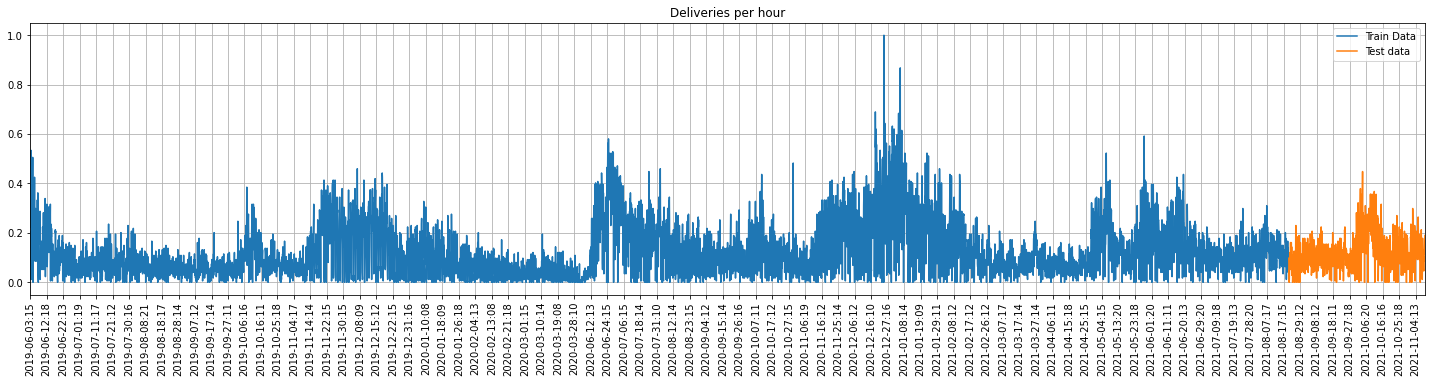

In [45]:
#feats = ['Total_paquetes', 'TotalPaquetesIngresados', 'No_Clientes']
feats = ['No_Clientes']
pred_points = 1
window_len = 24
normalize = True
test_size = .1
X_train, y_train, X_test, y_test, sc = load_data(model_df, feats, ['No_Clientes'], window_len, pred_points, test_size, normalize)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
n = model_df.shape[0]
xtick_labels = model_df.index.tolist()[window_len+pred_points:int(n*(1-test_size))] + model_df.index.tolist()[int(n*(1-test_size))+window_len+pred_points:]
plot_time_serie(y_train[:,0,-1], y_test[:,0,-1], xtick_labels)

In [46]:
sc['min']['No_Clientes']

1

In [16]:
model = Sequential()
def oneStepModel(X_train, pred_points):
    window_len = X_train.shape[1]
    n_features = X_train.shape[2]
    model.add(GRU(2*window_len, activation='relu', return_sequences=True, input_shape=(window_len, n_features)))
    #model.add(Dropout(0.2))
    model.add(GRU(window_len, activation='relu', return_sequences=False, input_shape=(2*window_len, n_features)))
    #model.add(Dropout(0.2))
    model.add(Dense(pred_points))
    model.compile(loss = 'mse', metrics='mae', optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3))
    print(model.summary())
    return model
#model = oneStepModel(X_train, pred_points)

In [ ]:

model = Sequential()
#def oneStepModel1(X_train, pred_points):
batch_size = 1
window_len = X_train.shape[1]
n_features = X_train.shape[2]
model.add(GRU(window_len, batch_input_shape=(batch_size, window_len, n_features), stateful=True, return_sequences=True))
model.add(GRU(window_len, batch_input_shape=(batch_size, window_len, n_features), stateful=True))
model.add(Dense(pred_points))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(X_train, y_train, epochs=1, batch_size=batch_size, validation_split = 0.2, shuffle=False)
	model.reset_states()

In [ ]:
# def EncDecModel(X_train, pred_points):
#     n_features = X_train.shape[2]
#     window_len = X_train.shape[1]
    
#     # Encoder
#     encoder_inputs = Input(shape=(window_len, n_features))
#     units = max(100, window_len)
#     encoder_l1 = GRU(units, return_state=True)
#     #encoder_l1 = LSTM(unit1, return_state=True)
#     encoder_outputs1, encoder_states1 = encoder_l1(encoder_inputs)
#     #encoder_states1 = encoder_outputs1[1:]

#     #Bridge
#     decoder_inputs = RepeatVector(pred_points)(encoder_outputs1)

#     # Decoder
#     decoder_l1 = GRU(units, return_sequences=True, input_shape=(units, n_features))(decoder_inputs, initial_state = encoder_states1)
#     #decoder_l1 = LSTM(units2, return_sequences=True)(decoder_inputs, initial_state = encoder_states1)
#     decoder_outputs1 = TimeDistributed(Dense(1))(decoder_l1)

#     # Output
#     model = Model(encoder_inputs, decoder_outputs1)
#     model.compile(loss = 'mse', metrics='mae', optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3))
#     print(model.summary())
#     return model

# model = EncDecModel(X_train, pred_points)

In [ ]:
def EncDecModel(X_train, pred_points):
    n_features = X_train.shape[2]
    window_len = X_train.shape[1]
    
    # Encoder
    encoder_inputs = Input(shape=(window_len, n_features))
    # units = max(100, window_len)
    units = window_len
    encoder_l1 = GRU(units, activation='relu', return_state=True)
    #encoder_l1 = LSTM(unit1, return_state=True)
    encoder_outputs1, encoder_states1 = encoder_l1(encoder_inputs)
    #encoder_states1 = encoder_outputs1[1:]

    #Bridge
    decoder_inputs = RepeatVector(pred_points)(encoder_outputs1)

    # Decoder
    decoder_l1 = GRU(units, activation='relu', return_sequences=True, input_shape=(units, n_features))(decoder_inputs, initial_state = encoder_states1)
    #decoder_l1 = LSTM(units2, return_sequences=True)(decoder_inputs, initial_state = encoder_states1)
    decoder_outputs1 = TimeDistributed(Dense(1))(decoder_l1)

    # Output
    model = Model(encoder_inputs, decoder_outputs1)
    model.compile(loss = 'mse', metrics='mae', optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3))
    print(model.summary())
    return model

model = EncDecModel(X_train, pred_points)

In [ ]:
def EncDec2Model(X_train, pred_points):
    n_features = X_train.shape[2]
    window_len = X_train.shape[1]
    
    # Encoder
    encoder_inputs = Input(shape=(window_len, n_features))
    units = max(100, window_len)

    encoder_l1 = GRU(units, return_sequences=True, return_state=True)
    encoder_outputs1, encoder_states1 = encoder_l1(encoder_inputs)

    encoder_l2 = GRU(units, return_state=True)    
    encoder_outputs2, encoder_states2 = encoder_l2(encoder_outputs1)
    
    #encoder_states1 = encoder_outputs1[1:]

    #Bridge
    decoder_inputs = RepeatVector(pred_points)(encoder_outputs2)

    # Decoder
    decoder_l1 = GRU(units, return_sequences=True, input_shape=(units, n_features))(decoder_inputs, initial_state = encoder_states1)
    decoder_l2 = GRU(units, return_sequences=True, input_shape=(units, n_features))(decoder_l1, initial_state = encoder_states2)
    decoder_outputs1 = TimeDistributed(Dense(1))(decoder_l2)

    # Output
    model = Model(encoder_inputs, decoder_outputs1)
    model.compile(loss = 'mse', metrics='mae', optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3))
    print(model.summary())
    return model

model = EncDecModel(X_train, pred_points)

In [65]:
model = Sequential()
def MultiStepConvModel(X_train, pred_points):
    n_timesteps,n_features = X_train.shape[1], X_train.shape[2]
    model.add(Conv1D(filters=32, kernel_size=11, activation='relu', input_shape=(n_timesteps, n_features)))    
    model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))    
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    model.add(RepeatVector(pred_points))

    model.add(GRU(window_len, activation='relu', return_sequences=True))
    model.add(Dropout(0.25))    
    model.add(TimeDistributed(Dense(32)))
    model.add(TimeDistributed(Dense(1)))    
    model.compile(loss='mse', metrics='mae', optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-4, ))
    print(model.summary())
    return model
    
model = MultiStepConvModel(X_train, pred_points)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 14, 32)            384       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 4, 64)             22592     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 2, 64)             0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 128)               0         
_________________________________________________________________
repeat_vector_13 (RepeatVect (None, 1, 128)            0         
_________________________________________________________________
gru_13 (GRU)                 (None, 1, 24)             11016     
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 24)           

In [66]:
#Train the model
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 80)
#history = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_split = 0.1, shuffle = False, callbacks = [early_stop])
history = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_data = (X_test, y_test), shuffle = False, callbacks = [early_stop])

Epoch 1/200
60/60 [==============================] - 2s 11ms/step - loss: 0.0142 - mae: 0.0856 - val_loss: 0.0041 - val_mae: 0.0493
Epoch 2/200
60/60 [==============================] - 0s 7ms/step - loss: 0.0076 - mae: 0.0646 - val_loss: 0.0038 - val_mae: 0.0492
Epoch 3/200
60/60 [==============================] - 0s 8ms/step - loss: 0.0072 - mae: 0.0630 - val_loss: 0.0037 - val_mae: 0.0480
Epoch 4/200
60/60 [==============================] - 0s 7ms/step - loss: 0.0069 - mae: 0.0603 - val_loss: 0.0035 - val_mae: 0.0468
Epoch 5/200
60/60 [==============================] - 0s 7ms/step - loss: 0.0065 - mae: 0.0579 - val_loss: 0.0034 - val_mae: 0.0455
Epoch 6/200
60/60 [==============================] - 0s 8ms/step - loss: 0.0064 - mae: 0.0563 - val_loss: 0.0033 - val_mae: 0.0448
Epoch 7/200
60/60 [==============================] - 1s 9ms/step - loss: 0.0061 - mae: 0.0554 - val_loss: 0.0033 - val_mae: 0.0445
Epoch 8/200
60/60 [==============================] - 0s 8ms/step - loss: 0.0059 - 

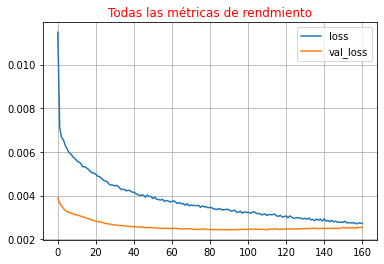

In [60]:
hpd = pd.DataFrame(history.history)
#hpd.to_csv('GRU_norm_100epochs_3feats_dropout02_bst_loss.csv')
hpd[['loss', 'val_loss']].plot()
#hpd[['mae', 'val_mae']].plot()
plt.title('Todas las métricas de rendmiento', c='r')
plt.grid(True)
plt.show()

In [62]:
model.save('models/Modelo'+tienda+'Win24ConvEncUVv2')

INFO:tensorflow:Assets written to: models/ModeloTienda2Win24ConvEncUVv2/assets


In [ ]:
# import keras
# model = keras.models.load_model('ModeloTienda2Win10v2')
# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 29, 58)            10440     
_________________________________________________________________
dropout (Dropout)            (None, 29, 58)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 29, 58)            20358     
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 58)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 58)                20358     
_________________________________________________________________
dropout_2 (Dropout)          (None, 58)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

(7632, 1, 1)
(7632, 1, 1)


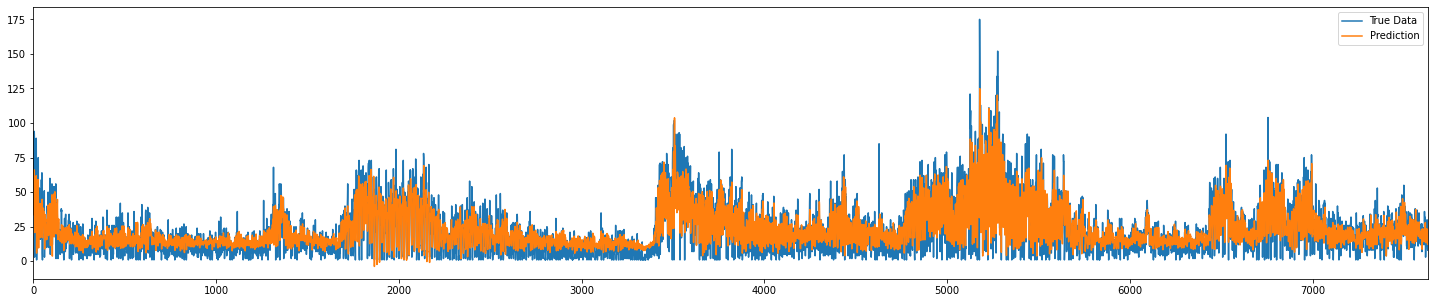

76.08226272428142
6.677574789202313
0.3335116614461183


In [61]:
# Single point train reconstruction
predictions = model.predict(X_train)
print(predictions.shape)
print(y_train.shape)
if normalize:
    predictions = predictions[:,0,0]*(sc['max']['No_Clientes'] - sc['min']['No_Clientes']) + sc['min']['No_Clientes']
    label_train = y_train[:,0,0]*(sc['max']['No_Clientes'] - sc['min']['No_Clientes']) + sc['min']['No_Clientes']
plot_results(predictions[:],label_train[:])
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(mean_squared_error(predictions,label_train))
print(mean_absolute_error(predictions,label_train))
print(mean_absolute_percentage_error(predictions,label_train))

In [63]:
# Single point prediction
predictions = model.predict(X_test)
print(predictions.shape)
print(predictions.shape)
if normalize:
    predictions = predictions[:,0,0]*(sc['max']['No_Clientes'] - sc['min']['No_Clientes']) + sc['min']['No_Clientes']
    label_test = y_test[:,0,0]*(sc['max']['No_Clientes'] - sc['min']['No_Clientes']) + sc['min']['No_Clientes']
#plot_results(predictions[:],label_test[:])
plotly_results(predictions[:],label_test[:])
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(mean_squared_error(predictions,label_test))
print(mean_absolute_error(predictions,label_test))
print(mean_absolute_percentage_error(predictions,label_test))

(826, 1, 1)
(826, 1, 1)


76.79277727070699
6.777511143511202
0.32643145308644944


(11,)


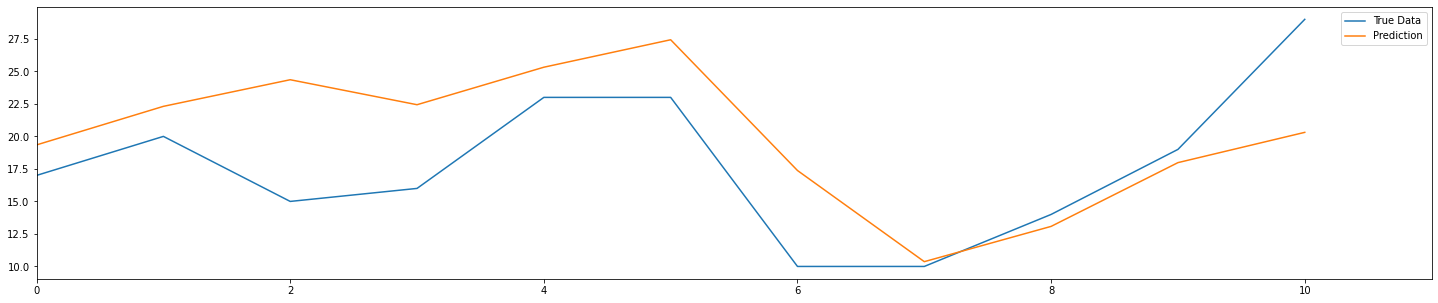

26.97989808344829
4.142869277433915
0.19669997259343946


In [64]:
# Autoregresive prediction
num = 620
pred_hor = 11
test_sample = X_test[num,:,:]
test_sample = test_sample[np.newaxis,:,:]
predictions = predict_sequence_full_univar(model, test_sample, pred_points, pred_hor) 
print(predictions.shape)
if normalize:
    predictions = predictions*(sc['max']['No_Clientes'] - sc['min']['No_Clientes']) + sc['min']['No_Clientes']
    label_test = y_test[num:num+pred_hor,0,0]*(sc['max']['No_Clientes'] - sc['min']['No_Clientes']) + sc['min']['No_Clientes']
plot_results(predictions,label_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(mean_squared_error(predictions,label_test))
print(mean_absolute_error(predictions,label_test))
print(mean_absolute_percentage_error(predictions,label_test))

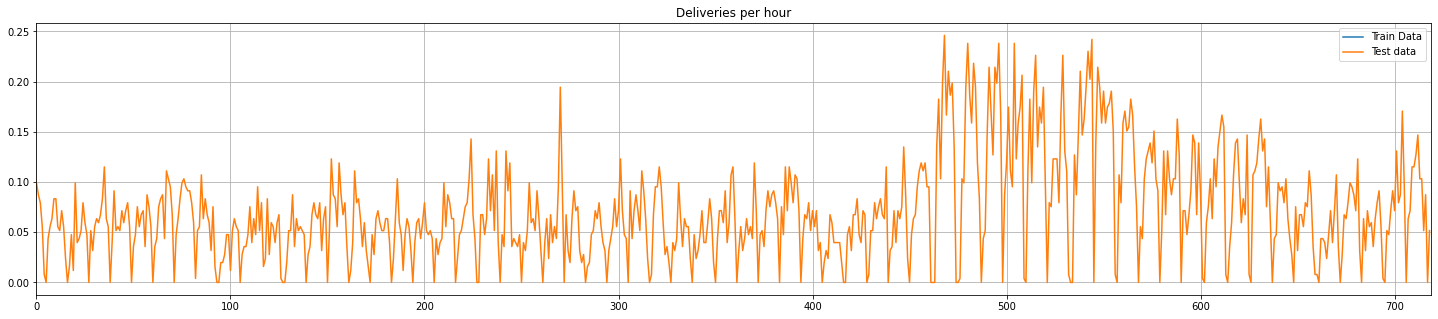

In [54]:
plot_time_serie([], y_test[:,0,0])

(786, 11)
(786, 11, 1)


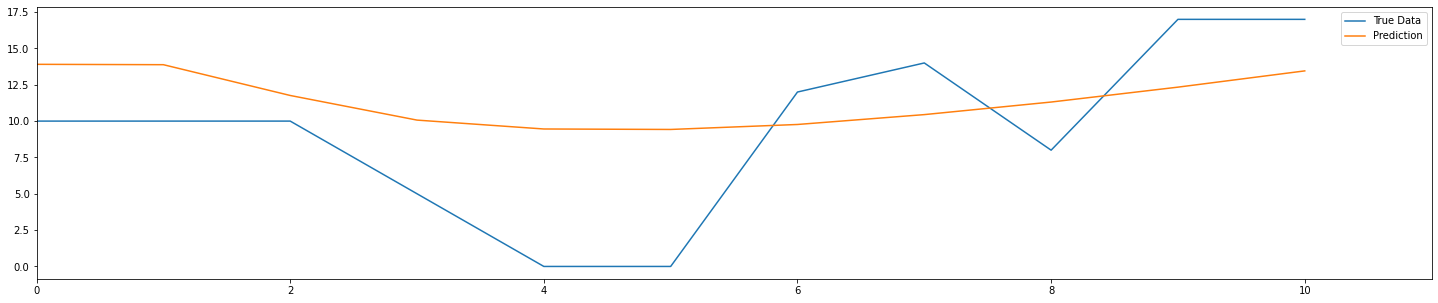

101.91897810621472
7.595739856572607
0.558810325590117


In [45]:
# Multi point prediction
predictions = model.predict(X_test)[:,:,0]
pos = 480
print(predictions.shape)
print(y_test.shape)
if normalize:
    predictions = predictions*(sc['max']['No_Clientes'] - sc['min']['No_Clientes']) + sc['min']['No_Clientes']
    label_test = y_test[:,:,0]*(sc['max']['No_Clientes'] - sc['min']['No_Clientes']) + sc['min']['No_Clientes']

plot_results(predictions[pos,:],label_test[pos,:])
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(mean_squared_error(predictions,label_test))
print(mean_absolute_error(predictions,label_test))
print(mean_absolute_percentage_error(predictions,label_test))